In [1]:
#importaciones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import shapiro, normaltest, anderson, levene, kstest, zscore, boxcox
import scipy.stats as stats
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import hdbscan
from minisom import MiniSom
from sklearn.metrics import silhouette_score

In [2]:
dataframe = pd.read_csv("muestra4s.csv")
dataframe.head(5)

,id,sensor1,sensor2,sensor3,sensor4
0,388937,0.332645,0.312709,0.066802,0.223234
1,90665,0.114415,0.010050,0.043108,0.222393
2,62420,0.089782,0.154589,0.101575,0.090151
3,20018,0.242456,0.101617,0.063159,0.158376
4,57736,0.130230,0.067402,0.066449,0.141199


# EDA 
Como punto de partida inicial para el análisis exploratorio de los datos se utilizo el siguiente recurso de IBM: 
https://www.ibm.com/docs/es/spss-modeler/saas?topic=understanding-collecting-initial-data <br>
En esta fase inicial pretendemos responder preguntas como: <br>
- ¿Qué atributos (columnas) de la base de datos parecen más prometedores?
- ¿Qué atributos no parecen relevantes y se pueden excluir? 
- ¿Cómo se distribuyen los datos?
- ¿Qué tipo de técnicas tiene más sentido usar?

In [3]:
print("Renglones y columnas: " + str(dataframe.shape))
print("Data types: \n" + str(dataframe.dtypes))
print("Revisando nulos en el dataframe:\n " + str(dataframe.isnull().any()))

Renglones y columnas: (300, 5)
Data types: 
id           int64
sensor1    float64
sensor2    float64
sensor3    float64
sensor4    float64
dtype: object
Revisando nulos en el dataframe:
 id         False
sensor1    False
sensor2    False
sensor3    False
sensor4    False
dtype: bool


Podemos observar que tenemos un dataframe de 300 renglones y 5 columnas, donde todas las columnas menos el id son de tipo float y que no contamos con valores nulos en el df

In [4]:
dataframe.describe()

,id,sensor1,sensor2,sensor3,sensor4
count,300.000000,300.000000,300.000000,300.000000,300.000000
mean,195072.120000,0.203864,0.196685,0.198745,0.202088
std,133924.921824,0.130148,0.203096,0.218348,0.126481
min,14.000000,0.013153,0.004468,0.004946,0.005244
25%,68315.250000,0.107719,0.059639,0.043634,0.105538
50%,195907.500000,0.178133,0.138402,0.115086,0.182516
75%,341503.000000,0.281055,0.254938,0.253272,0.278511
max,396768.000000,0.718866,0.949300,0.962168,0.566642


- Donde count nos indica que en ningún registro existen valores faltantes <br>
- Mean (media o promedio) nos muestra que todos los datos trabajan en un rango de valores entre 0.19 y 0.20 <br>
- std (desv. estandar) nos muestra que los sensores 2 y 3 son los que más variación presentan respecto a la media, esto puede afectar en las futuras técnicas de clustering que ocupemos
- min muestra los valores mínimos de cada sensor, los valores mínimos casi alcanzan el cero
- 25, 50 (o mediana) y 75 representan los cuartiles donde podemos ver que
    -  el 25% de los datos de los sensores 2 y 3 son valores muy bajos
    -  el Q2 o 50% o mediana es el valor central de los datos, podemos realizar una comparación entre el promedio y la mediana para ver si existe algún sesgo para los datos
    -  el tercer cuartil muestra que para el sensor 1 y 4 existe una cuarta parte de los datos con valores mayores a 0.28 y 0.27 respectivamente, lo que parece demostrar una disperción de valores
- max nos muestra los valores máximos de cada sensor, los sensores 2 y 3 muestran rangos parecidos entre mínimos y máximos, mientras que los sensores 1 y 4 tienen distribuciones completamente diferentes a todos los sensores
  


In [5]:
dataframe_sinid = dataframe.drop("id", axis=1, inplace= True) # borrar col 1
dataframe.head(2)

,sensor1,sensor2,sensor3,sensor4
0,0.332645,0.312709,0.066802,0.223234
1,0.114415,0.010050,0.043108,0.222393


In [6]:
df_desc = dataframe.describe()
df_comparacion = pd.DataFrame({"promedio": dataframe.mean(),"mediana": dataframe.median()})
df_comparacion

,promedio,mediana
sensor1,0.203864,0.178133
sensor2,0.196685,0.138402
sensor3,0.198745,0.115086
sensor4,0.202088,0.182516


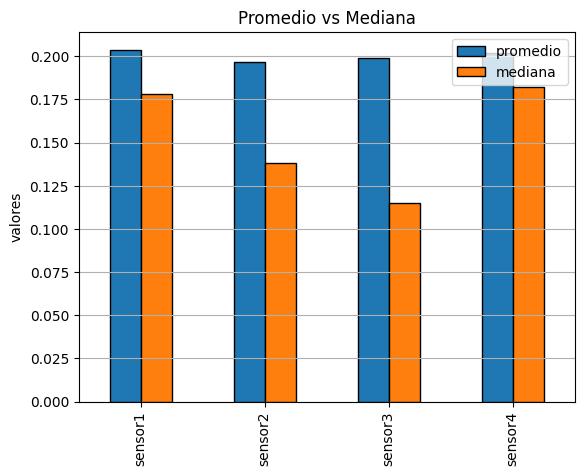

In [7]:
df_comparacion.plot(kind="bar",edgecolor = "black")
plt.title("Promedio vs Mediana")
plt.ylabel("valores")
plt.grid(axis="y")
plt.show()

In [8]:
df_skew = dataframe.skew()
df_skew

sensor1    1.018613
sensor2    1.639237
sensor3    1.547334
sensor4    0.829939
dtype: float64

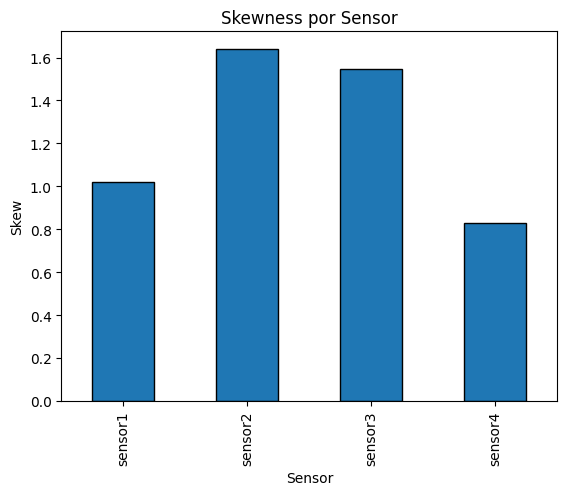

In [9]:
#plt.figure(figsize=(8,5))
df_skew.plot(kind='bar', edgecolor='black')
plt.title("Skewness por Sensor")
plt.ylabel("Skew")
plt.xlabel("Sensor")
plt.show()

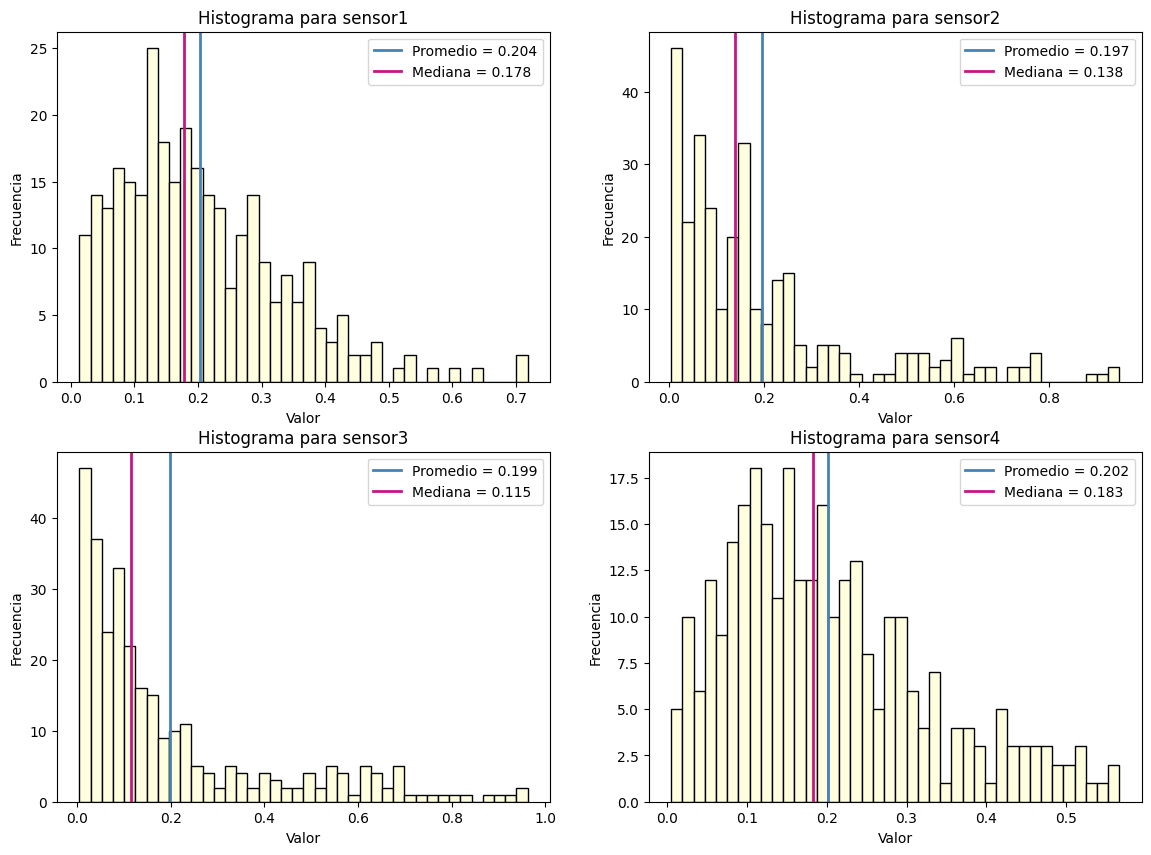

In [10]:
# columans a iterar
columnas = ["sensor1", "sensor2", "sensor3", "sensor4"]

plt.figure(figsize=(14, 10))

for i, col in enumerate(columnas, 1): # 1,sensor1;2,sensor2;...
    plt.subplot(2, 2, i)

    # histograma del sensor
    plt.hist(dataframe[col], bins=40, edgecolor='black', color='lightyellow') # bin = buckets o agrupamiento de datos en el hist

    # mean y q2 
    promedio = df_comparacion.loc[col, "promedio"]
    mediana = df_comparacion.loc[col, "mediana"]
    plt.axvline(promedio, color='steelblue', linewidth=2, label=f'Promedio = {promedio:.3f}') 
    plt.axvline(mediana, color='mediumvioletred', linewidth=2, label=f'Mediana = {mediana:.3f}')

    # textos
    plt.title(f"Histograma para {col}")
    plt.xlabel("Valor")
    plt.ylabel("Frecuencia")
    plt.legend()
    
plt.show()


In [11]:
columnas = dataframe.columns

resultados = []

for col in dataframe.columns:
    datos = dataframe[col]

    # shapiro d agostino y darling
    shapiro_stat, shapiro_p = shapiro(datos)
    dago_stat, dago_p = normaltest(datos)
    ad_result = anderson(datos)

    resultados.append({
        "Variable": col,
        "Shapiro p": shapiro_p,
        "DAgostino p": dago_p,
        "Anderson stat": ad_result.statistic,
        "Anderson crit 5%": ad_result.critical_values[2],  
    })

df_normalidad = pd.DataFrame(resultados)
df_normalidad = df_normalidad.set_index("Variable")
df_normalidad = df_normalidad.round(6)

display(df_normalidad)

stat, p_levene = levene(
    dataframe["sensor1"],
    dataframe["sensor2"],
    dataframe["sensor3"],
    dataframe["sensor4"]
)

df_levene = pd.DataFrame({
    "Levene stat": [stat],
    "Levene p": [p_levene]
}).round(2)

display(df_levene)

resultados_ks = []

for col in dataframe.columns:
    datos = zscore(dataframe[col])
    ks_stat, ks_p = kstest(datos, "norm")

    resultados_ks.append({
        "Variable": col,
        "KS stat": ks_stat,
        "KS p": ks_p
    })

df_ks = pd.DataFrame(resultados_ks).set_index("Variable").round(2)

display(df_ks)

,Shapiro p,DAgostino p,Anderson stat,Anderson crit 5%
Variable,,,,
sensor1,0.0,0.000000,4.120931,0.777
sensor2,0.0,0.000000,19.669212,0.777
sensor3,0.0,0.000000,23.028408,0.777
sensor4,0.0,0.000001,5.020782,0.777


,Levene stat,Levene p
0,10.88,0.0


,KS stat,KS p
Variable,,
sensor1,0.08,0.03
sensor2,0.19,0.00
sensor3,0.20,0.00
sensor4,0.09,0.01


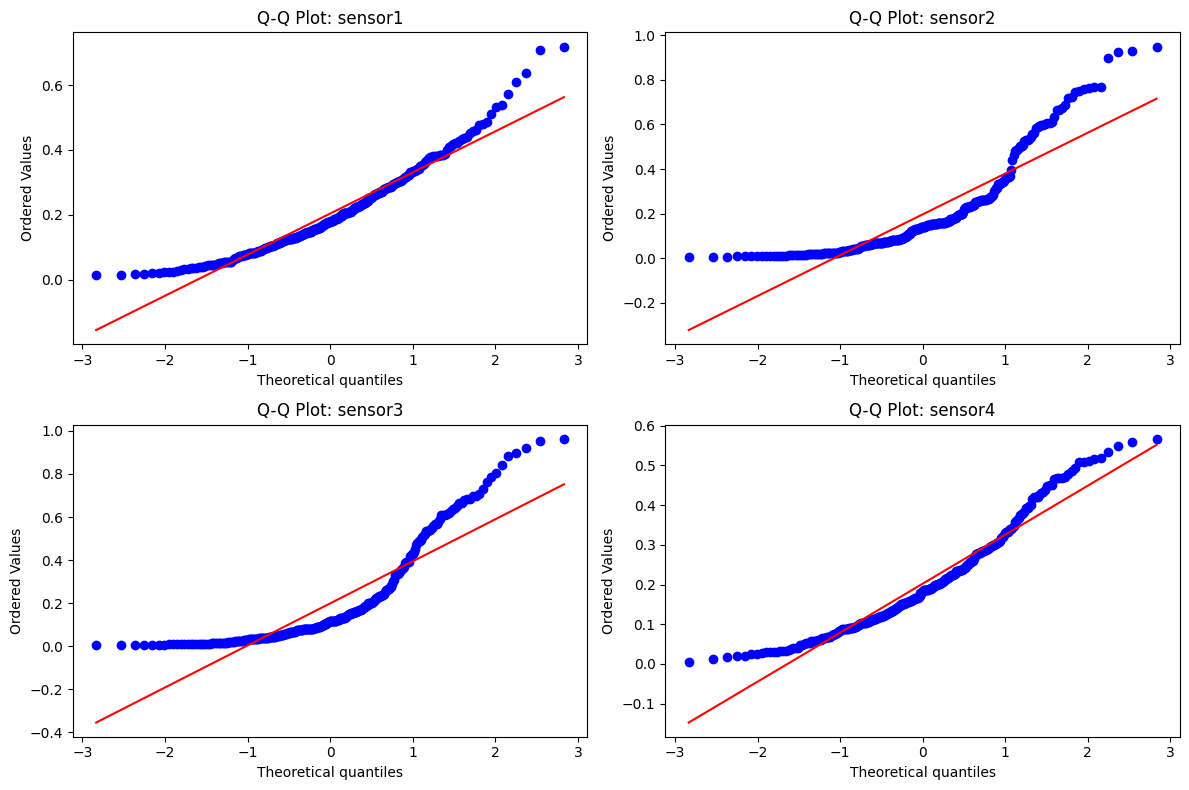

In [12]:
# q-q plot para mostar desviaciones marcadas en las colas y curvaturas
plt.figure(figsize=(12, 8))

for i, col in enumerate(columnas, 1):
    plt.subplot(2, 2, i)
    stats.probplot(dataframe[col], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot: {col}")

plt.tight_layout()
plt.show()

## Conclusiones del EDA
1. Los valores observados en los sensores rondan entre el 0 y el 1 (0.004468 y 0.962168) pero la dispersión de datos es diferente para cada sensor <br>
2. La mediana es menor al promedio en todos los sensores lo que indica que el grado de asimetría (skewness) posee un sesgo positivo para todos los sensores (colas hacia la derecha) <br>
3. La desviación estandar y la dispersion de los datos en los sensores 2 y 3 es alta, hay que tener cuidado con los algoritmos que se apliquen, los sensores 1 y 4 son menos pronunciados pero aún poseen sesgos
4. No hay valores faltantes y el tipo de dato es igual para todos los valores<br>
5. Las pruebas de no normalidad muestran que ninguno de los sensores sigue una distribución normal y confirma sesgos positivos <br>
6. La prueba de Levene indica que es obligatorio estandarizar los sensores antes de hacer clustering, ya que contamos con varianzas muy diferentes p = 0

# Transformaciones estadísticas

In [13]:
df = dataframe[['sensor1', 'sensor2', 'sensor3', 'sensor4']].copy()

## Normalización
Todos los datos ya se encuentran en un rango de valores cercano al 0 y el 1, además todos son del mismo tipo, por lo que aplicar un algoritmo como minmaxscaler no parece tener repercusiones importantes <br>
Al aplicar minmax podemos ver que las medianas, los cuartiles y las dispersiones se mantienen iguales; las medias se mueven proporcionalmente y las relaciones se mantienen iguales <br>
Esta transformación puede resultar positiva para los métodos de clustering que se van a aplciar <br>

In [14]:
df.describe()

,sensor1,sensor2,sensor3,sensor4
count,300.000000,300.000000,300.000000,300.000000
mean,0.203864,0.196685,0.198745,0.202088
std,0.130148,0.203096,0.218348,0.126481
min,0.013153,0.004468,0.004946,0.005244
25%,0.107719,0.059639,0.043634,0.105538
50%,0.178133,0.138402,0.115086,0.182516
75%,0.281055,0.254938,0.253272,0.278511
max,0.718866,0.949300,0.962168,0.566642


In [15]:
minmax_scaler = MinMaxScaler()
df_minmax = minmax_scaler.fit_transform(df)
df_minmax = pd.DataFrame(df_minmax, columns=df.columns)
df_minmax.describe()

,sensor1,sensor2,sensor3,sensor4
count,300.000000,300.000000,300.000000,300.000000
mean,0.270239,0.203440,0.202460,0.350631
std,0.184420,0.214955,0.228106,0.225297
min,0.000000,0.000000,0.000000,0.000000
25%,0.134000,0.058393,0.040418,0.178650
50%,0.233777,0.141755,0.115062,0.315769
75%,0.379618,0.265095,0.259424,0.486761
max,1.000000,1.000000,1.000000,1.000000


In [16]:
desc_original = df.describe()
desc_minmax = df_minmax.describe()
comparacion = pd.concat([desc_original.add_prefix("orig_"), desc_minmax.add_prefix("minmax_")],axis=1)
comparacion

,orig_sensor1,orig_sensor2,orig_sensor3,orig_sensor4,minmax_sensor1,minmax_sensor2,minmax_sensor3,minmax_sensor4
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,0.203864,0.196685,0.198745,0.202088,0.270239,0.203440,0.202460,0.350631
std,0.130148,0.203096,0.218348,0.126481,0.184420,0.214955,0.228106,0.225297
min,0.013153,0.004468,0.004946,0.005244,0.000000,0.000000,0.000000,0.000000
25%,0.107719,0.059639,0.043634,0.105538,0.134000,0.058393,0.040418,0.178650
50%,0.178133,0.138402,0.115086,0.182516,0.233777,0.141755,0.115062,0.315769
75%,0.281055,0.254938,0.253272,0.278511,0.379618,0.265095,0.259424,0.486761
max,0.718866,0.949300,0.962168,0.566642,1.000000,1.000000,1.000000,1.000000


## Estandarización 
"Una puntuación z representa el número de desviaciones estándar que un punto de datos se aleja de la media de su distribución" <br>
Con standard scaler vamos a buscar que cada columna tenga una media de 0 y una desviacion de 1 mientras preservamos la forma de la distribucion, es decir centrar la distribución normalizar la dispersión e igualar el peso estadístico entre las columnas <br>
Todo esto con el fin de buscar que ningún sensor domine y encontrar Clusters reales <br>

In [17]:
std_scaler = StandardScaler()
df_zscore = std_scaler.fit_transform(df)
df_zscore = pd.DataFrame(df_zscore , columns=df.columns)
print("-----Describe del dataframe escalado: -----")
display(df_zscore .describe())
print("-----Head del dataframe después de zscore: ------")
display(df_zscore .head(5))
print("-----Head del dataframe antes de zscore: ----")
display(df.head(5))

-----Describe del dataframe escalado: -----


,sensor1,sensor2,sensor3,sensor4
count,3.000000e+02,3.000000e+02,3.000000e+02,3.000000e+02
mean,-2.013204e-16,1.598721e-16,-1.006602e-16,-1.184238e-17
std,1.001671e+00,1.001671e+00,1.001671e+00,1.001671e+00
min,-1.467791e+00,-9.480136e-01,-8.890520e-01,-1.558908e+00
25%,-7.399747e-01,-6.759089e-01,-7.115680e-01,-7.646304e-01
50%,-1.980425e-01,-2.874506e-01,-3.837844e-01,-1.549962e-01
75%,5.940894e-01,2.873038e-01,2.501431e-01,6.052326e-01
max,3.963667e+00,3.711894e+00,3.502197e+00,2.887096e+00


-----Head del dataframe después de zscore: ------


,sensor1,sensor2,sensor3,sensor4
0,0.991147,0.572233,-0.605285,0.167471
1,-0.688440,-0.920485,-0.713982,0.160808
2,-0.878027,-0.207617,-0.445763,-0.886485
3,0.297019,-0.468872,-0.621997,-0.346173
4,-0.566721,-0.637621,-0.606907,-0.482205


-----Head del dataframe antes de zscore: ----


,sensor1,sensor2,sensor3,sensor4
0,0.332645,0.312709,0.066802,0.223234
1,0.114415,0.010050,0.043108,0.222393
2,0.089782,0.154589,0.101575,0.090151
3,0.242456,0.101617,0.063159,0.158376
4,0.130230,0.067402,0.066449,0.141199


## Transformación log 
"Se utiliza para convertir datos a una escala logarítmica, ayuda a estabilizar la varianza y hacer que los datos se distribuyan de manera más normal y reducir el impacto de los valores extremos o outliers"<br>
Con esta transformación buscamos reducir la asimetría (skew) de los valores, evitar que valores muy grandes afecten las estadisticas y comprimir colas largas

In [18]:
df_log = np.log1p(df)
df_log = pd.DataFrame(df_log, columns=df.columns)

desc_original = df.describe()
desc_log = df_log.describe()

comparacion_log = pd.concat([desc_original.add_prefix("orig_"),desc_log.add_prefix("log_")], axis=1)

print("--- comparación desc -----")
display(comparacion_log)

df_skew_og = df.skew()
df_skew_post = df_log.skew()
df_skew_comparacion = pd.concat([df_skew_og.add_prefix("orig_"), df_skew_post.add_prefix("post_")], axis=0)
print("--- skew comparacion -----")
display(df_skew_comparacion)



--- comparación desc -----


,orig_sensor1,orig_sensor2,orig_sensor3,orig_sensor4,log_sensor1,log_sensor2,log_sensor3,log_sensor4
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,0.203864,0.196685,0.198745,0.202088,0.180019,0.167068,0.166915,0.178779
std,0.130148,0.203096,0.218348,0.126481,0.103944,0.153106,0.164052,0.101896
min,0.013153,0.004468,0.004946,0.005244,0.013068,0.004458,0.004933,0.005230
25%,0.107719,0.059639,0.043634,0.105538,0.102303,0.057928,0.042709,0.100332
50%,0.178133,0.138402,0.115086,0.182516,0.163930,0.129626,0.108931,0.167645
75%,0.281055,0.254938,0.253272,0.278511,0.247684,0.227086,0.225749,0.245696
max,0.718866,0.949300,0.962168,0.566642,0.541665,0.667470,0.674050,0.448935


--- skew comparacion -----


orig_sensor1    1.018613
orig_sensor2    1.639237
orig_sensor3    1.547334
orig_sensor4    0.829939
post_sensor1    0.714200
post_sensor2    1.324047
post_sensor3    1.281869
post_sensor4    0.619572
dtype: float64

Como podemos ver los promedios (mean) bajaron ya que log nos ayuda a comprimir los valores máß grandes<br>
La desviación estándar (std) también bajo ya que log reduce la distancia entre los valores grandes y pequeños lo que nos indica menor dispersión entre los datos<br>
Los valores máximos también fueron reducidos <br>
Pero la parte más importante que es el skew mejoró para todos los sensores lo que se traduce en una distribución más simétrica <br>

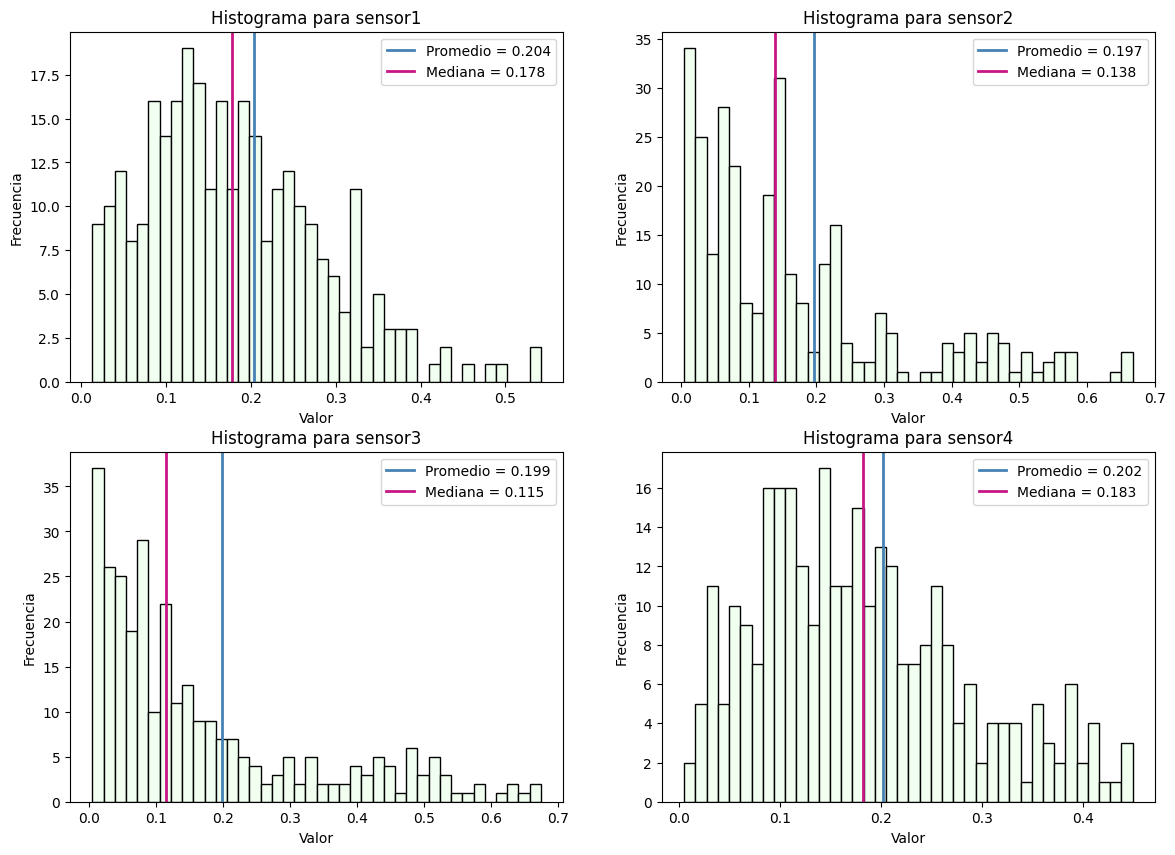

In [19]:
# aplicando primero log y luego standar scaler
df_logz = std_scaler.fit_transform(df_log)
df_logz = pd.DataFrame(df_logz , columns=df_log.columns)

# df con media y mediana
df_log_desc = df_logz.describe()
log_comparacion = pd.DataFrame({"promedio": dataframe.mean(),"mediana": dataframe.median()})

# columans a iterar
columnas = ["sensor1", "sensor2", "sensor3", "sensor4"]

plt.figure(figsize=(14, 10))

for i, col in enumerate(columnas, 1): # 1,sensor1;2,sensor2;...
    plt.subplot(2, 2, i)

    # histograma del sensor
    plt.hist(df_log[col], bins=40, edgecolor='black', color='honeydew') # bin = buckets o agrupamiento de datos en el hist

    # mean y q2 como lineas vert
    promedio = log_comparacion.loc[col, "promedio"]
    mediana = log_comparacion.loc[col, "mediana"]
    plt.axvline(promedio, color='steelblue', linewidth=2, label=f'Promedio = {promedio:.3f}') 
    plt.axvline(mediana, color='mediumvioletred', linewidth=2, label=f'Mediana = {mediana:.3f}')

    # textos
    plt.title(f"Histograma para {col}")
    plt.xlabel("Valor")
    plt.ylabel("Frecuencia")
    plt.legend()
    
plt.show()

## Box cox
"Es una técnica estadística que se utiliza para estabilizar la varianza y hacer que los datos se ajusten más a una distribución normal"

In [20]:
df_boxcox = df.copy()

lambdas = {}  

for col in df.columns:
    transformed, lam = boxcox(df[col])
    df_boxcox[col] = transformed
    lambdas[col] = lam
print("--- Boxcox antes de la estandarizacion: ---\n")
display(df_boxcox.describe(), lambdas)

scaler = StandardScaler()
df_final = scaler.fit_transform(df_boxcox)
df_final = pd.DataFrame(df_final, columns=df.columns)
print("--- Boxcox después de la estandarizacion: ---\n")
display(df_final.describe())

--- Boxcox antes de la estandarizacion: ---



,sensor1,sensor2,sensor3,sensor4
count,300.000000,300.000000,300.000000,300.000000
mean,-1.263703,-1.779057,-1.927235,-1.242512
std,0.356952,0.817806,0.954874,0.338268
min,-2.115594,-3.639731,-3.983070,-2.175426
25%,-1.499514,-2.276063,-2.633839,-1.476235
50%,-1.262996,-1.698922,-1.916240,-1.229455
75%,-1.005470,-1.229481,-1.271349,-0.997932
max,-0.310092,-0.051818,-0.038482,-0.507451


{'sensor1': np.float64(0.38250460092871397),
 'sensor2': np.float64(0.15770228237127984),
 'sensor3': np.float64(0.11399616274397927),
 'sensor4': np.float64(0.40480830418696906)}

--- Boxcox después de la estandarizacion: ---



,sensor1,sensor2,sensor3,sensor4
count,3.000000e+02,3.000000e+02,3.000000e+02,3.000000e+02
mean,9.473903e-17,-1.657933e-16,4.144833e-17,-1.065814e-16
std,1.001671e+00,1.001671e+00,1.001671e+00,1.001671e+00
min,-2.390557e+00,-2.279005e+00,-2.156588e+00,-2.762519e+00
25%,-6.617288e-01,-6.087462e-01,-7.412337e-01,-6.920948e-01
50%,1.982087e-03,9.815152e-02,1.153338e-02,3.866416e-02
75%,7.246473e-01,6.731363e-01,6.880295e-01,7.242440e-01
max,2.675998e+00,2.115570e+00,1.981317e+00,2.176642e+00


Al aplicar Boxcox podemos ver que los valores para los sensores se acercan más a la forma normal, la distribución ahora es más simétrica y comprimida <br>
Los valores lambdas encontrados por box cox son las potencias óptimas para que los datos se parezcan lo más posible a una distribución normal <br>
Después de aplicar estandarización a la box cox podemos ver que las variables quedaron en la misma escala yla forma original de la distribución se conserva, pero ahora con una media de 0 y una desviación estandar de 1 (cercanas)

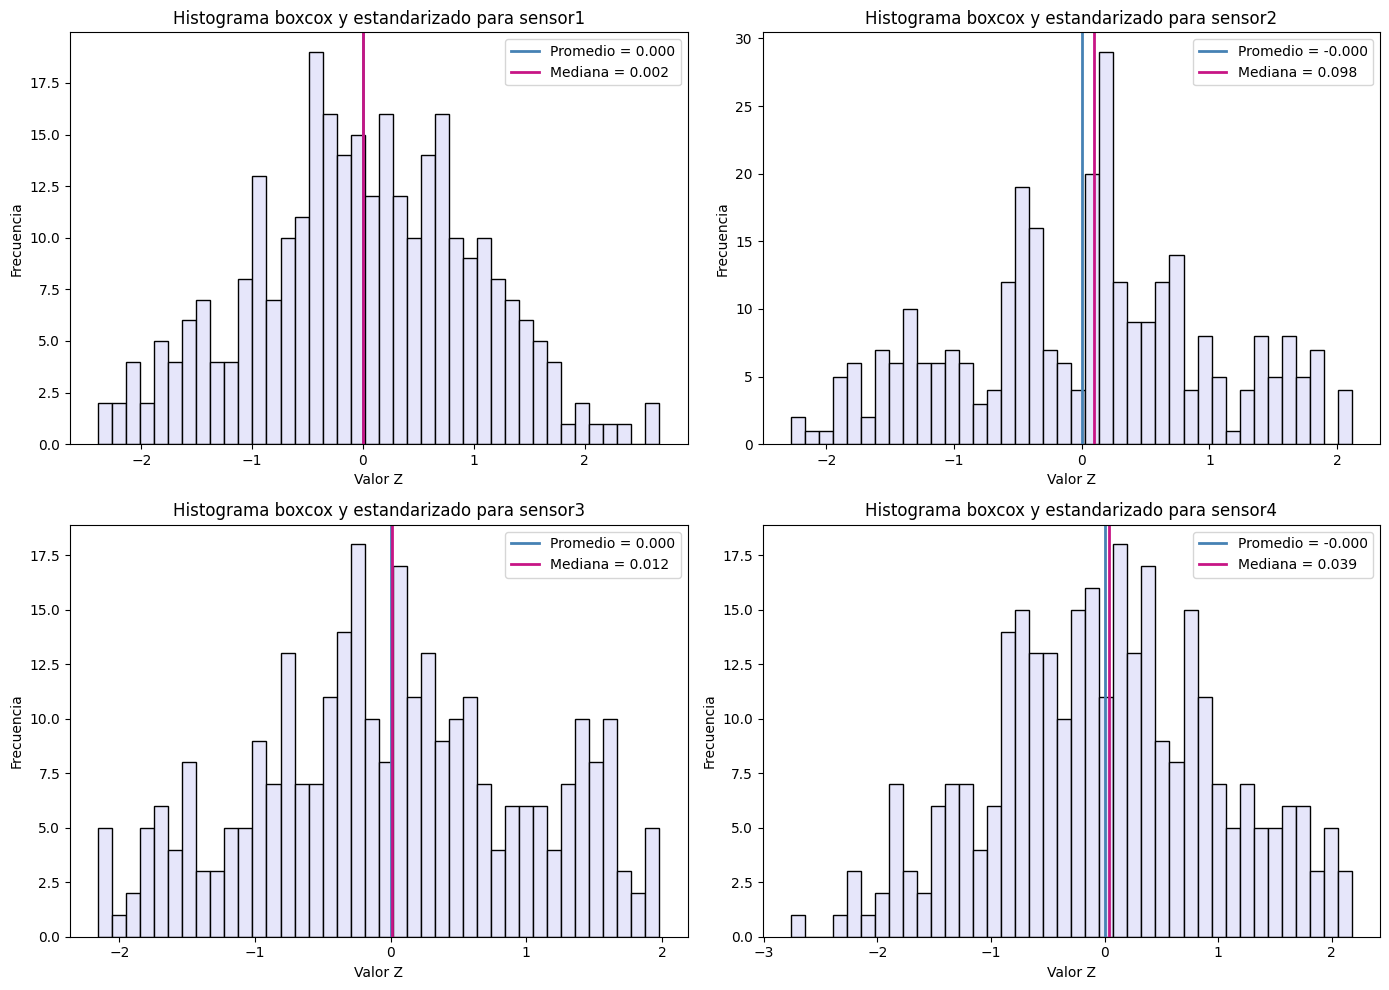

In [21]:
df_final_desc = df_final.describe()
final_comparacion = pd.DataFrame({
    "promedio": df_final.mean(),
    "mediana": df_final.median()
})

plt.figure(figsize=(14, 10))

for i, col in enumerate(columnas, 1):
    plt.subplot(2, 2, i)

    plt.hist(df_final[col], bins=40, edgecolor='black', color='lavender')

    promedio = final_comparacion.loc[col, "promedio"]
    mediana = final_comparacion.loc[col, "mediana"]

    plt.axvline(promedio, color='steelblue', linewidth=2, 
                label=f'Promedio = {promedio:.3f}')
    plt.axvline(mediana, color='mediumvioletred', linewidth=2, 
                label=f'Mediana = {mediana:.3f}')

    plt.title(f"Histograma boxcox y estandarizado para {col}")
    plt.xlabel("Valor Z")
    plt.ylabel("Frecuencia")
    plt.legend()

plt.tight_layout()
plt.show()


# Aprendizaje automático

## Agrupación:
### K-Means
K-means agrupa puntos de datos similares en grupos minimizando la distancia entre los puntos de datos de un grupo con su centroide o valor medio k. El objetivo principal del algoritmo k-means es minimizar las distancias totales entre los puntos y su centroide de grupo asignado.


In [22]:
ks = [3, 4, 5, 15]

clusters_resultados = {}

for k in ks: # un modelo para cada k
    modelo = KMeans(n_clusters=k, random_state=42)
    modelo.fit(df_final)

    clusters_resultados[k] = modelo.labels_

    print(f"\n=== K-Means con k = {k} ===")
    print("Centroides del cluster:")
    print(pd.DataFrame(modelo.cluster_centers_, columns=df_final.columns)) 
    print("\nPrimeros labels:") # labels para saber a que grupo (fila) pertenecen
    print(modelo.labels_[:20])

df_clusters = df_final.copy()
for k in ks:
    df_clusters[f"cluster_k{k}"] = clusters_resultados[k] # ageragr una col nueva al df clusters para cada k

df_clusters.head(5)



=== K-Means con k = 3 ===
Centroides del cluster:
    sensor1   sensor2   sensor3   sensor4
0  1.038788  1.098803  1.086113  0.889768
1 -0.144699 -0.118424 -0.088850 -0.123057
2 -1.093716 -1.236998 -1.287940 -0.938862

Primeros labels:
[0 2 1 1 1 0 0 1 0 2 0 1 2 0 1 1 2 2 2 2]

=== K-Means con k = 4 ===
Centroides del cluster:
    sensor1   sensor2   sensor3   sensor4
0  0.301819  0.287511  0.217698  0.267043
1 -0.421236 -0.505976 -0.459620 -0.402234
2 -1.345415 -1.394120 -1.448899 -1.133575
3  1.112254  1.297074  1.364709  0.991606

Primeros labels:
[0 1 1 0 1 0 0 1 3 2 3 0 1 3 1 0 2 1 2 1]

=== K-Means con k = 5 ===
Centroides del cluster:
    sensor1   sensor2   sensor3   sensor4
0  0.489845  0.348399  0.262024  0.365460
1 -0.438777 -0.139916 -0.179417 -0.706610
2 -1.366352 -1.362270 -1.434753 -1.353243
3  1.111533  1.328312  1.400652  1.001284
4 -0.380835 -0.960814 -0.787338  0.423134

Primeros labels:
[0 4 1 0 1 0 0 1 3 2 3 1 1 3 1 0 2 4 4 1]

=== K-Means con k = 15 ===
Centroide

,sensor1,sensor2,sensor3,sensor4,cluster_k3,cluster_k4,cluster_k5,cluster_k15
0,1.025267,0.878090,-0.420878,0.350753,0,0,0,12
1,-0.588721,-1.827815,-0.750119,0.344663,2,1,4,14
2,-0.872263,0.198199,-0.090122,-0.874000,1,1,1,5
3,0.476608,-0.172232,-0.463950,-0.166403,1,0,0,1
4,-0.426184,-0.511730,-0.424965,-0.323941,1,1,1,1


### PCA
"El análisis de componentes principales (PCA) reduce el número de dimensiones de grandes conjuntos de datos a componentes principales que conservan la mayor parte de la información original. Esto se logra transformando variables potencialmente correlacionadas en un conjunto más pequeño de variables, llamadas componentes principales"

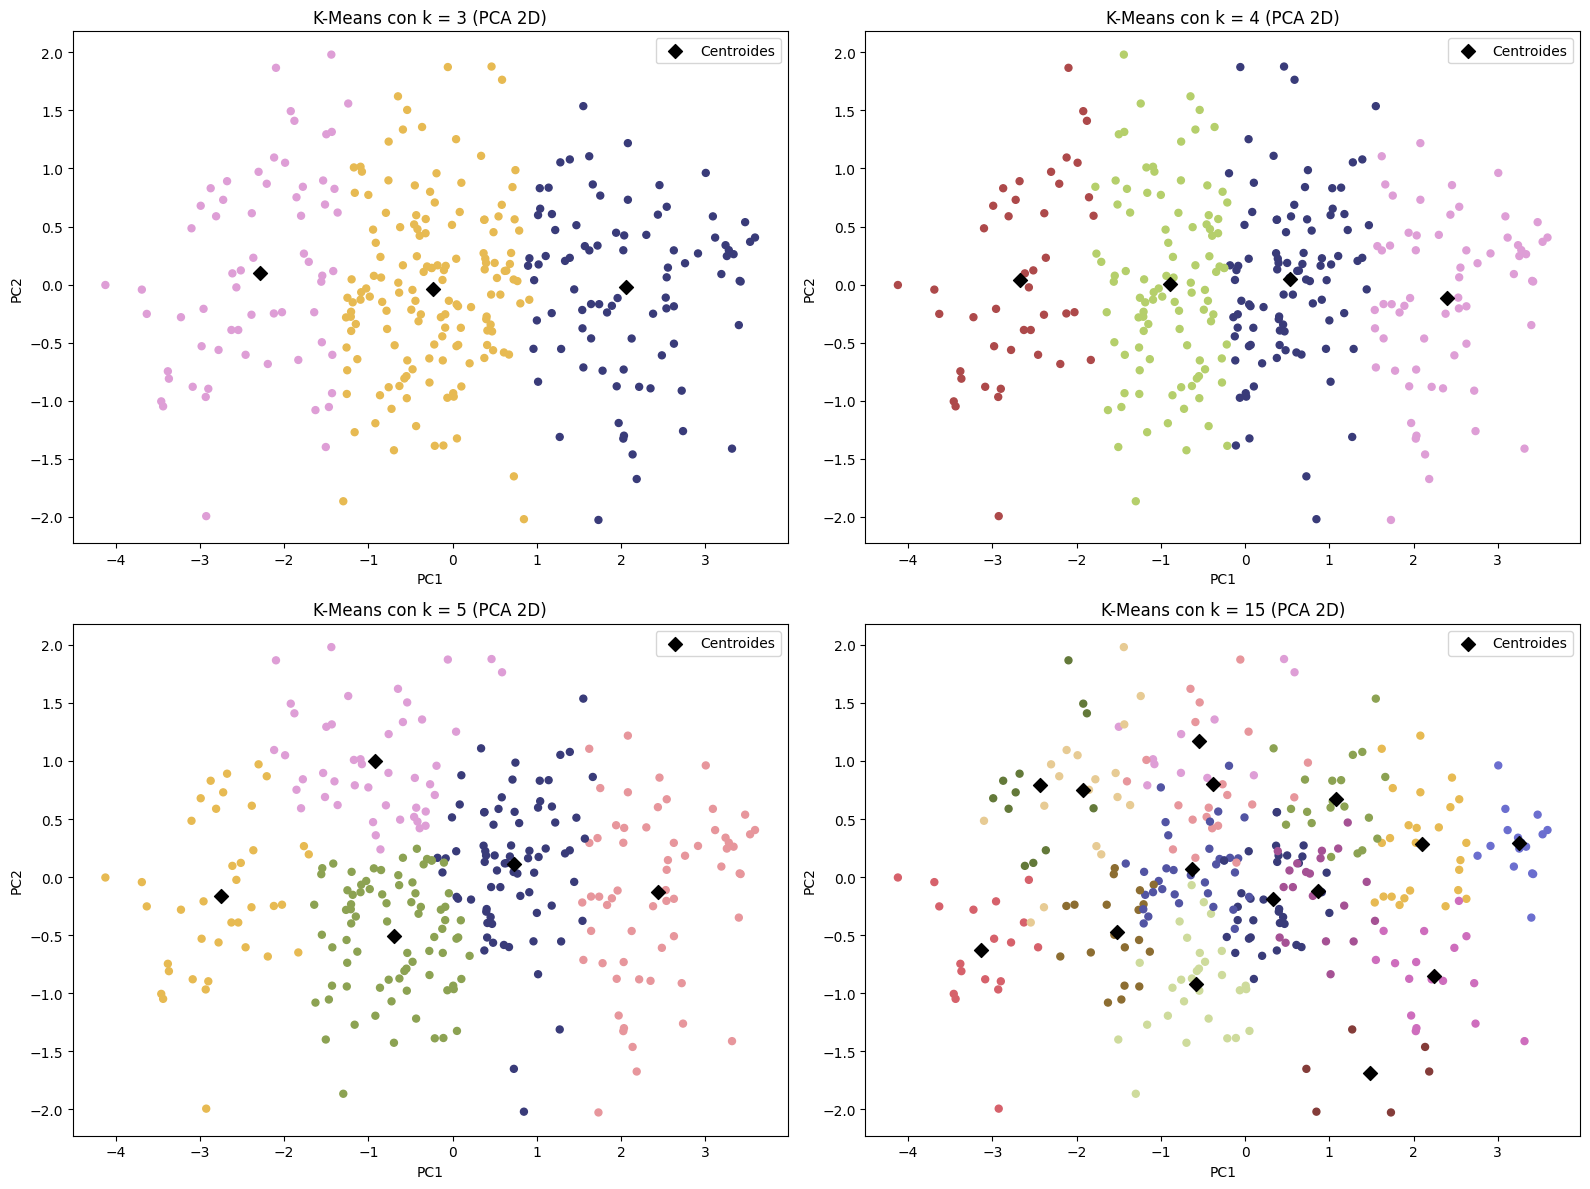

In [23]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_final)

df_plot = pd.DataFrame(pca_result, columns=["PC1", "PC2"])
for k in ks:
    df_plot[f"cluster_k{k}"] = df_clusters[f"cluster_k{k}"]

# subplot 
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()  

for idx, k in enumerate(ks):
    ax = axes[idx]

    # scatter de los puntos
    scatter = ax.scatter(df_plot["PC1"],df_plot["PC2"], c=df_plot[f"cluster_k{k}"],cmap="tab20b",s=25)

    # centroides 
    modelo = KMeans(n_clusters=k, random_state=42).fit(df_final)
    centroides_df = pd.DataFrame(modelo.cluster_centers_, columns=df_final.columns)
    centroides_pca = pca.transform(centroides_df)

    ax.scatter(centroides_pca[:, 0], centroides_pca[:, 1], c="black", s=50,marker="D", label="Centroides")

    ax.set_title(f"K-Means con k = {k} (PCA 2D)")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.legend()

plt.tight_layout()
plt.show()


### DBSCAN y HDBSCAN
"DBSCAN, que significa Agrupación Espacial Basada en la Densidad de Aplicaciones con Ruido, es un potente algoritmo de agrupación que agrupa puntos que están muy juntos en el espacio de datos, el algoritmo funciona definiendo los conglomerados como regiones densas separadas por regiones de menor densidad. Este enfoque permite al DBSCAN descubrir conglomerados de forma arbitraria e identificar los valores atípicos como ruido."<br>

Debido a que los datos que estamos pasando ya son datos transformados con box cox y cuenta con una forma parecida a la normal dbscan interpeta a todos los puntos como un solo clúster, lo que muestra que nuestras transformaciones funcionaron correctamente

Etiquetas encontradas por DBSCAN:
[0]


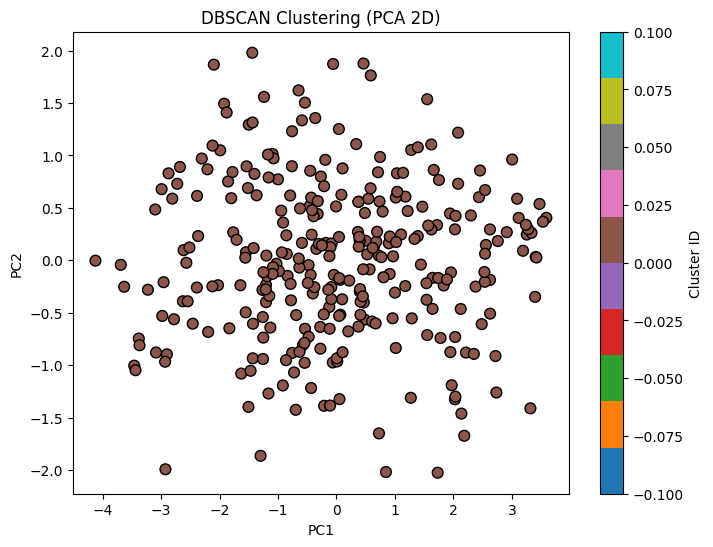

In [24]:
df_clusters = pd.DataFrame(index=df_final.index)
dbscan = DBSCAN(eps=1.5, min_samples=5)

dbscan.fit(df_final) # entrenamiento inicial
db_labels = dbscan.labels_

df_clusters["cluster_dbscan"] = db_labels # guardar en otro df

print("Etiquetas encontradas por DBSCAN:")
print(np.unique(db_labels))

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_final.iloc[:, :4])  # solo sensores

plt.figure(figsize=(8, 6))
plt.scatter(
    pca_result[:, 0],
    pca_result[:, 1],
    c=df_clusters["cluster_dbscan"],
    cmap="tab10",
    s=60,
    edgecolor="black"
)

plt.title("DBSCAN Clustering (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster ID")
plt.show()

Por otro lado "la agrupación en clúster espacial basada en densidad jerárquica (HDBSCAN)© utiliza el aprendizaje no supervisado para encontrar clústeres, o regiones densas, de un conjunto de datos" <br>
HDBSCAN encuentra 3 clusters reales y 1 cluster de ruid (-1), además arroja porcentajes de confianza para los clusters y todo esto sin elegir k

In [25]:
hdb = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=3, metric='euclidean', cluster_selection_method='eom')
hdb_labels = hdb.fit_predict(df_final) 

df_clusters["cluster_hdbscan"] = hdb_labels
df_clusters["hdbscan_prob"] = hdb.probabilities_

print("Clusters encontrados:", np.unique(hdb_labels))

Clusters encontrados: [-1  0  1  2]


C:\Users\leo\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\leo\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


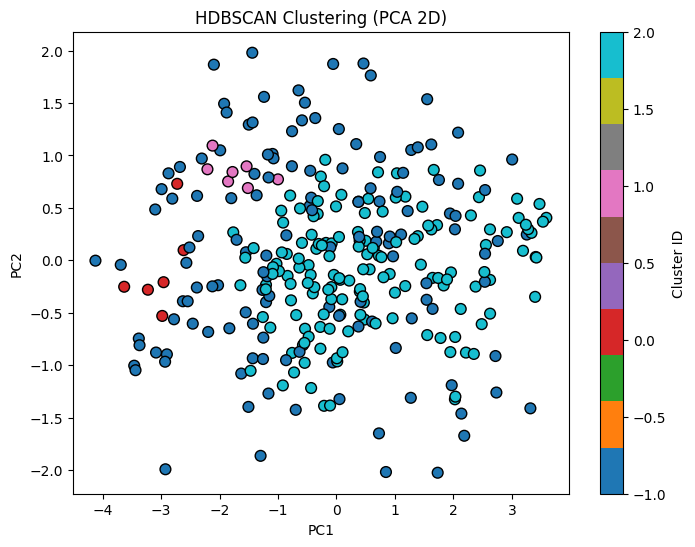

In [26]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_final.iloc[:, :4])

plt.figure(figsize=(8, 6))
plt.scatter(
    pca_result[:, 0],
    pca_result[:, 1],
    c=df_clusters["cluster_hdbscan"],
    cmap="tab10",
    s=60,
    edgecolor="black"
)

plt.title("HDBSCAN Clustering (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster ID")
plt.show()


### SOM
"Los mapas autoorganizados (SOM) son un tipo dered neuronal artificialque se utiliza para tareas de aprendizaje no supervisado, como la agrupación. Dado un conjunto de puntos de datos, el modelo aprende a dividir los datos en clusters. Los SOM proyectan datos multidimensionales complejos en una cuadrícula de dimensiones inferiores"

In [27]:
df_som = df_final.copy().values # los datos que entran al som deben de ir ya normalizados

# definir malla som
som_x = 10
som_y = 10
som = MiniSom(x=som_x, y=som_y, input_len=df_som.shape[1], sigma=1.0, learning_rate=0.5, neighborhood_function='gaussian',random_seed=42)

som.random_weights_init(df_som)
som.train_random(df_som, 2000)   # iteraciones
bmus = np.array([som.winner(x) for x in df_som]) # best machine unit para cada fila
som_labels = np.array([bx * som_y + by for bx, by in bmus]) # convertir bmus a un cluster del 0 al 99

df_clusters_som = df_final.copy()
df_clusters_som["SOM_cluster"] = som_labels

df_clusters_som.head(8)


,sensor1,sensor2,sensor3,sensor4,SOM_cluster
0,1.025267,0.878090,-0.420878,0.350753,96
1,-0.588721,-1.827815,-0.750119,0.344663,43
2,-0.872263,0.198199,-0.090122,-0.874000,91
3,0.476608,-0.172232,-0.463950,-0.166403,75
4,-0.426184,-0.511730,-0.424965,-0.323941,82
5,-0.951030,0.705310,0.762195,2.176642,49
6,0.200275,0.229499,0.440055,1.308526,48
7,-0.258136,-0.838313,-0.312541,-1.055843,60


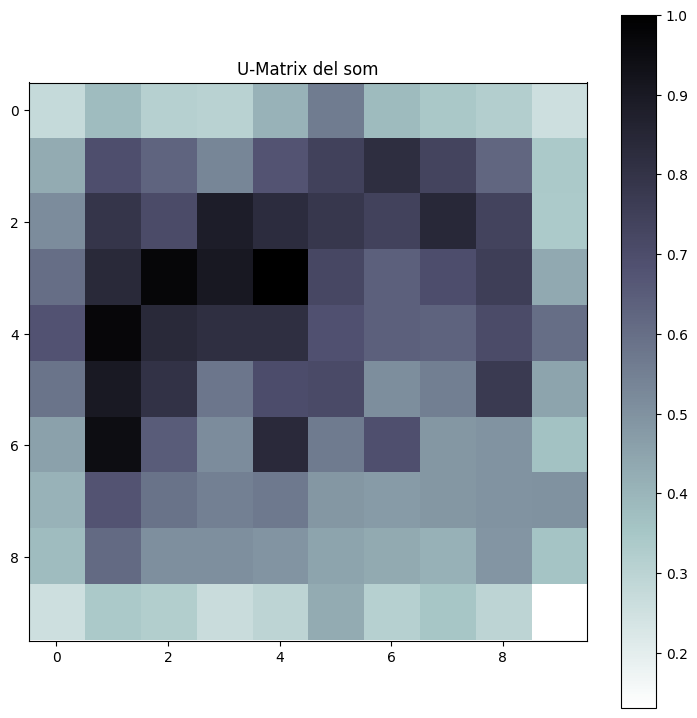

In [28]:
# ploteando la umatrix
plt.figure(figsize=(9, 9))
plt.title("U-Matrix del som")
u_matrix = som.distance_map()  # distancias entre neuronas
plt.imshow(u_matrix, cmap='bone_r')
plt.colorbar()
plt.show()


El mapa SOM de 10×10 organizó los 300 registros en un espacio bidimensional donde cada neurona representa un patrón distinto de comportamiento entre los sensores.
Cada observación fue asignada a una neurona (SOM_cluster), lo cual indica el prototipo más cercano en el mapa.
Las neuronas cercanas representan patrones similares, mientras que neuronas lejanas representan perfiles diferentes.
Para obtener clusters interpretables, se aplicó un K-Means adicional sobre los pesos del SOM.

In [29]:
ks = [3, 4, 5, 15]

som_weights = som.get_weights().reshape(-1, df_som.shape[1]) # sacar los pesos del som(100 neuronas con 4 pesos)

som_kmeans_labels = {}
for k in ks:
    modelo = KMeans(n_clusters=k, random_state=42)
    modelo.fit(som_weights)
    neuron_clusters = modelo.labels_
    som_kmeans_labels[k] = [neuron_clusters[c] for c in som_labels]

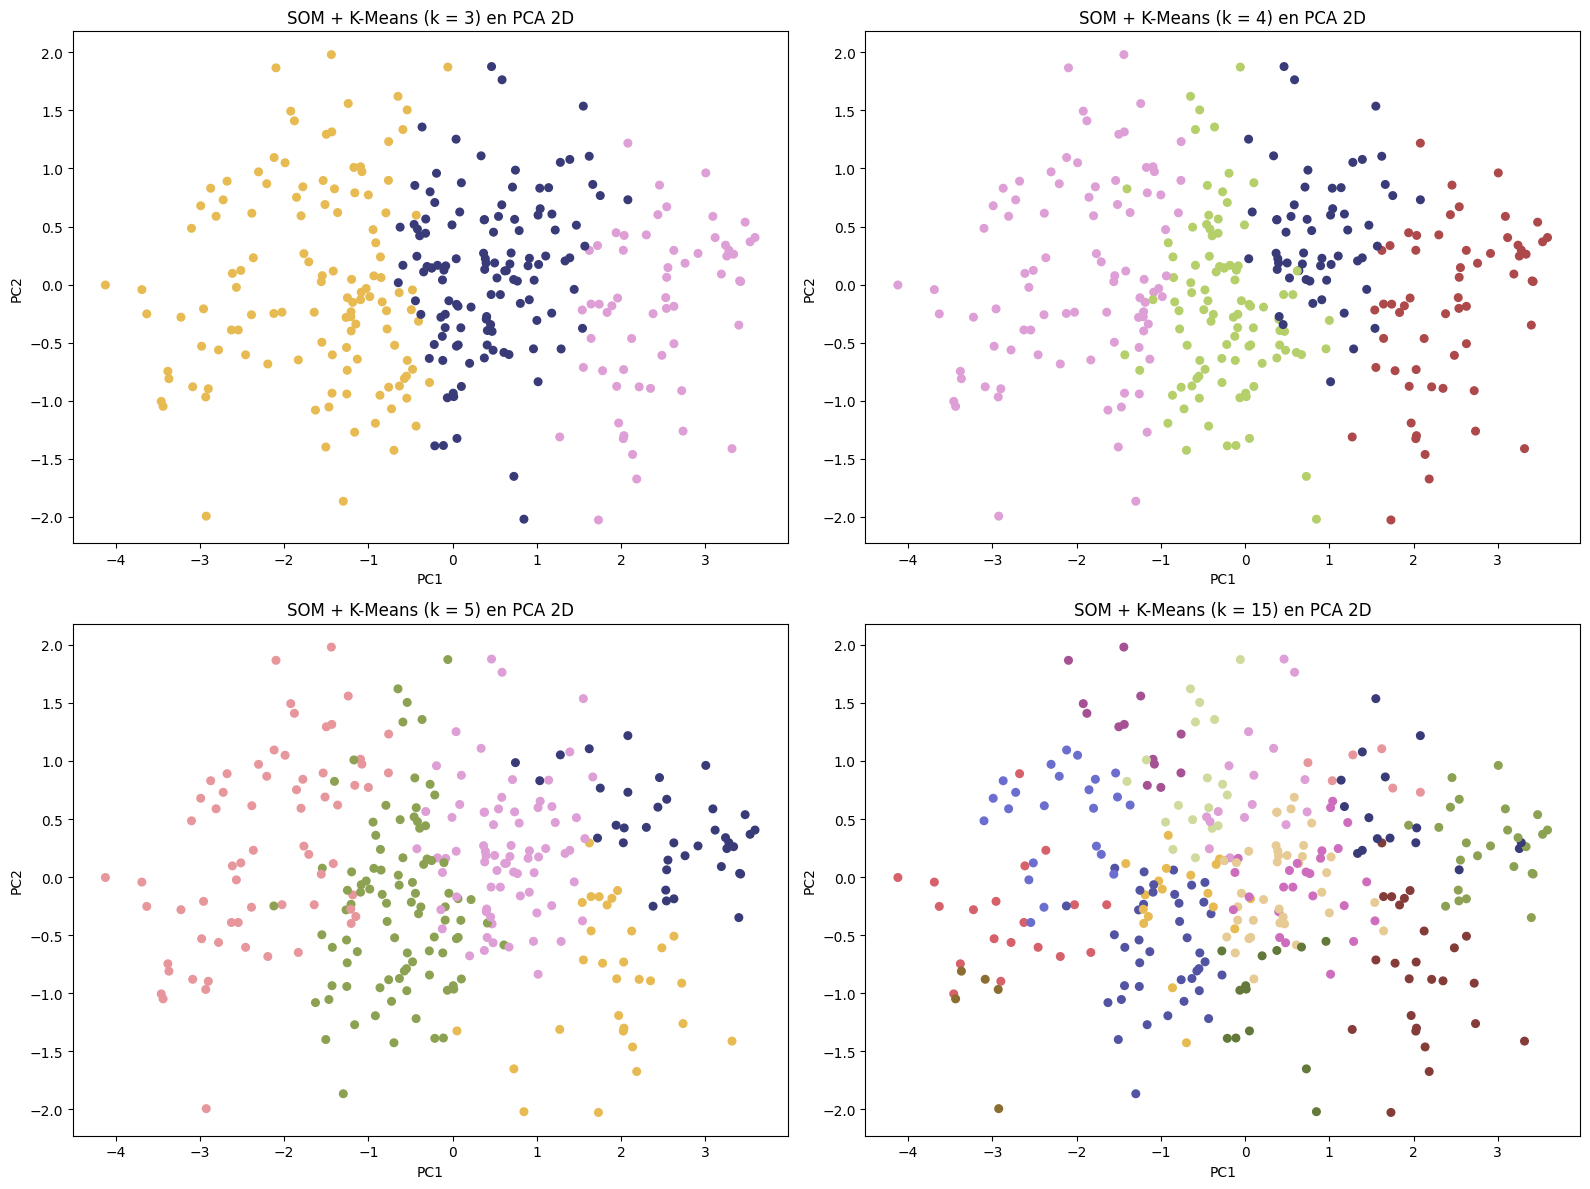

In [30]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_final)

df_plot = pd.DataFrame(pca_result, columns=["PC1", "PC2"])

for k in ks:
    df_plot[f"SOM_k{k}"] = som_kmeans_labels[k]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, k in enumerate(ks):
    ax = axes[idx]
    ax.scatter(df_plot["PC1"], df_plot["PC2"],c=df_plot[f"SOM_k{k}"],cmap="tab20b",s=30)
    ax.set_title(f"SOM + K-Means (k = {k}) en PCA 2D")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

plt.tight_layout()
plt.show()

# Evaluación
Para evaluar la calidad de los clústeres obtenidos se utilizó el Silhouette Score, una métrica estándar que cuantifica qué tan bien separados y qué tan compactos están los clusters <br>
Donde >1 indica una buena separación, 0 indica clusters traslapados y <-1 indica clusters mal hechos

In [38]:
silhouette_kmeans = {}

for k in ks:
    labels = clusters_resultados[k]
    sil = silhouette_score(df_final, labels)
    silhouette_kmeans[k] = sil
    print(f"Silhouette KMeans k={k}: {sil:.2f}")

Silhouette KMeans k=3: 0.31
Silhouette KMeans k=4: 0.24
Silhouette KMeans k=5: 0.26
Silhouette KMeans k=15: 0.21


In [39]:
if len(np.unique(db_labels)) > 1:
    sil_dbscan = silhouette_score(df_final, db_labels)
    print(f"Silhouette DBSCAN: {sil_dbscan:.2f}")
else:
    sil_dbscan = None
    print("DBSCAN encontró solo 1 cluster, no se puede calcular Silhouette")


DBSCAN encontró solo 1 cluster, no se puede calcular Silhouette


In [44]:
mask = hdb_labels != -1
if len(np.unique(hdb_labels[mask])) > 1:
    sil_hdbscan = silhouette_score(df_final[mask], hdb_labels[mask])
    print(f"Silhouette HDBSCAN (sin ruido): {sil_hdbscan:.2}")
else:
    sil_hdbscan = None
    print("HDBSCAN no tiene suficientes clusters válidos para Silhouette")


Silhouette HDBSCAN (sin ruido): 0.27


In [41]:
if len(np.unique(hdb_labels)) > 1:
    sil_hdbscan_all = silhouette_score(df_final, hdb_labels)
    print(f"Silhouette HDBSCAN (incluyendo ruido): {sil_hdbscan_all:.2f}")
else:
    sil_hdbscan_all = None


Silhouette HDBSCAN (incluyendo ruido): -0.05


In [42]:
silhouette_som = {}

for k in ks:
    labels = np.array(som_kmeans_labels[k])
    sil = silhouette_score(df_final, labels)
    silhouette_som[k] = sil
    print(f"Silhouette SOM+K-Means k={k}: {sil:.2f}")


Silhouette SOM+K-Means k=3: 0.27
Silhouette SOM+K-Means k=4: 0.21
Silhouette SOM+K-Means k=5: 0.22
Silhouette SOM+K-Means k=15: 0.18


In [45]:
tabla_sil = pd.DataFrame({
    "K-Means": silhouette_kmeans,
    "SOM+KMeans": silhouette_som
})

tabla_sil.loc["DBSCAN"] = [sil_dbscan, None]
tabla_sil.loc["HDBSCAN"] = [sil_hdbscan, sil_hdbscan_all]

print(tabla_sil)


          K-Means  SOM+KMeans
3        0.308969    0.269942
4        0.238064    0.207435
5        0.255001    0.215694
15       0.213500    0.179630
DBSCAN        NaN         NaN
HDBSCAN  0.267106   -0.047513


C:\Users\leo\AppData\Local\Temp\ipykernel_11268\1053555226.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tabla_sil.loc["DBSCAN"] = [sil_dbscan, None]


# Resultados finales
- Resultados Silhouette para K-Means <br>
    El mejor valor correspondió a k = 0.308969, indicando que este número de clústeres representa mejor la estructura interna de los datos
- Silhouette para DBSCAN<br>
  DBSCAN identificó únicamente un clúster, por lo que no es posible calcular el Silhouette Score. Esto sugiere que, tras las transformaciones aplicadas, los datos se volvieron muy homogéneos para este algoritmo.
- Silhouette para HDBSCAN<br>
  HDBSCAN detectó múltiples clústeres y un conjunto de puntos considerados ruido.
  Se reportan dos scores: 0.267106 y -0.05, el primero es el score sin ruido
- Silhouette para SOM + K-Means<br>
  Este modelo alcanzó un desempeño comparable a K-Means tradicional.<br>
  ***
El mejor algoritmo según Silhouette fue K-Means con k = 3 (0.3089). Aunque el valor no es alto, representa la mejor estructura de agrupación posible que obtuvimos dada la naturaleza de los datos<br>
Tenemos una hipótesis final de porque pudo haber pasado esto y es que parece ser que los valores son continuos y no parecen haber clusters claros, al ser datos obtenidos (supuestamente nosotros) de sensores que estaban midiendo procesos cognitivos continuamente y al ser una cantidad muy pequeña de la muestra podemos imaginar que con una muestra más grande o comparando distintos procesos cognitivos podemos llegar a encontrar agrupaciones más naturales que nos permitan llegar a un mejor resultado


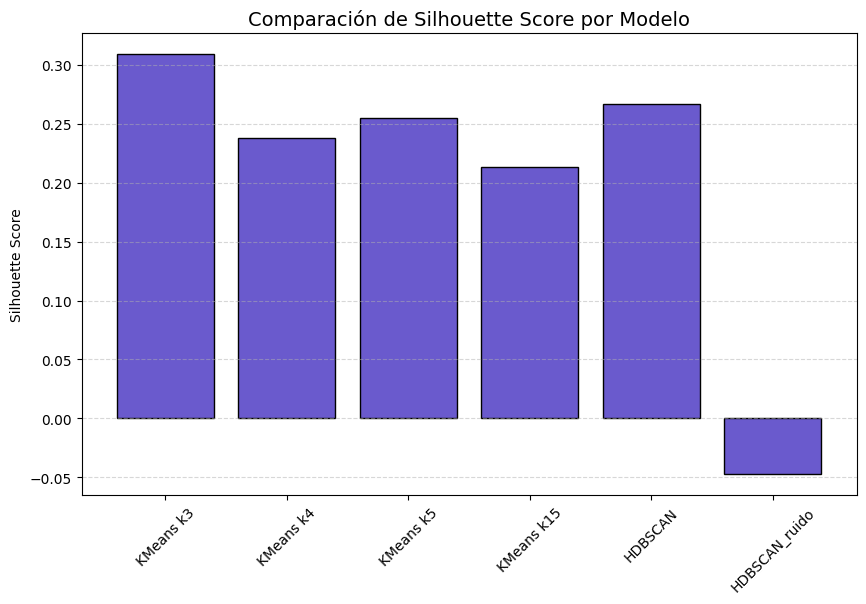

In [47]:
modelos = ["KMeans k3", "KMeans k4", "KMeans k5", "KMeans k15", "HDBSCAN", "HDBSCAN_ruido","SOM k3","SOM k4","SOM k5","SOM k15"]
scores = [0.308969, 0.238064, 0.255001, 0.213500, 0.267106, -0.047513, 0.269942, 0.207435, 0.215694, 0.179630]

plt.figure(figsize=(10,6))
plt.bar(modelos, scores, color="slateblue", edgecolor="black")
plt.title("Comparación de Silhouette Score por Modelo", fontsize=14)
plt.ylabel("Silhouette Score")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.show()